# De-wrap NORDIF Pattern.dat file

Håkon Wiik Ånes (hakon.w.anes@ntnu.no)

See the relevant package documentation for more details on the packages used here:
* kikuchipy: https://kikuchipy.org/en/stable/

Import required packages and print their versions

In [1]:
%matplotlib inline

from datetime import date
import importlib_metadata
import os

import dask.array as da
import matplotlib.pyplot as plt
import numpy as np

import kikuchipy as kp


# Data directories
sample = "325c"
dset_no = 3
dir_data = os.path.join("/home/hakon/phd/data/p/prover", sample, str(dset_no))
dir_nordif = os.path.join(dir_data, "nordif")
dir_kp = os.path.join(dir_data, "kp")

print("Run date: ", date.today())
print("\nSoftware versions\n------------------")
for pkg in ["dask", "kikuchipy", "matplotlib", "numpy"]:
    if pkg == "numpy":
        ver = np.__version__
    else:
        ver = importlib_metadata.version(pkg)
    print(pkg, ":", ver)

Run date:  2022-06-18

Software versions
------------------
dask : 2022.6.0
kikuchipy : 0.6.1
matplotlib : 3.5.2
numpy : 1.22.4


Load patterns lazily (not into RAM)

In [2]:
s = kp.load(os.path.join(dir_nordif, "Pattern.dat"), lazy=True)
nr = s.axes_manager.navigation_shape[1]  # Number of rows
s

<LazyEBSD, title: Pattern, dimensions: (1028, 1026|60, 60)>

Get first, second and last column of patterns

In [3]:
s_col0 = s.inav[0]
s_col1 = s.inav[1]
s_col_last = s.inav[-1]

Increase signal-to-noise ratio (enhance Kikuchi pattern)

In [4]:
s_col0.remove_static_background()
s_col1.remove_static_background()
s_col_last.remove_static_background()

s_col0.remove_dynamic_background()
s_col1.remove_dynamic_background()
s_col_last.remove_dynamic_background()

dtype = np.float32
s_col0.rescale_intensity(dtype_out=dtype)
s_col1.rescale_intensity(dtype_out=dtype)
s_col_last.rescale_intensity(dtype_out=dtype)

Match patterns (it's done all-to-all, instead of 1-1 which is enough, so we have to extract the diagonal)

In [5]:
metric_ncc = kp.indexing.similarity_metrics.NormalizedCrossCorrelationMetric(
    n_experimental_patterns=nr, n_dictionary_patterns=nr
)

ncc_01_all = metric_ncc(s_col0.data, s_col1.data)
ncc_0last_all = metric_ncc(s_col0.data, s_col_last.data)
ncc_01 = da.diagonal(ncc_01_all).compute()
ncc_0last = da.diagonal(ncc_0last_all).compute()

Plot normalized cross-correlation (NCC) scores

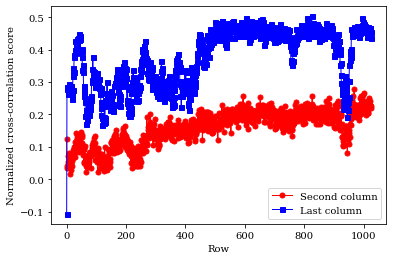

In [6]:
fig, ax = plt.subplots()
ax.plot(ncc_01, "r-o", label="Second column")
ax.plot(ncc_0last, "b-s", label="Last column")
ax.set_xlabel("Row")
ax.set_ylabel("Normalized cross-correlation score")
ax.legend();

Do we have to de-wrap?

In [7]:
if ncc_0last.mean() > ncc_01.mean():
    print("De-wrap!")
else:
    print("Don't de-wrap")

De-wrap!


The first column is clearly more similar to the last column than the second, hence we need to de-wrap.

Create a deepcopy and shift the first column last

In [8]:
s2 = s.deepcopy()
s2.data = da.roll(s2.data, shift=-1, axis=1)

Extract the new first, second and last column

In [9]:
s2_col0 = s2.inav[0]
s2_col1 = s2.inav[1]
s2_col_last = s2.inav[-1]

Increase signal-to-noise ratio (enhance Kikuchi pattern)

In [10]:
s2_col0.remove_static_background()
s2_col1.remove_static_background()
s2_col_last.remove_static_background()

s2_col0.remove_dynamic_background()
s2_col1.remove_dynamic_background()
s2_col_last.remove_dynamic_background()

s2_col0.rescale_intensity(dtype_out=dtype)
s2_col1.rescale_intensity(dtype_out=dtype)
s2_col_last.rescale_intensity(dtype_out=dtype)

Match patterns

In [11]:
ncc2_01_all = metric_ncc(s2_col0.data, s2_col1.data)
ncc2_0last_all = metric_ncc(s2_col0.data, s2_col_last.data)
ncc2_01 = da.diagonal(ncc2_01_all).compute()
ncc2_0last = da.diagonal(ncc2_0last_all).compute()

Plot NCC scores

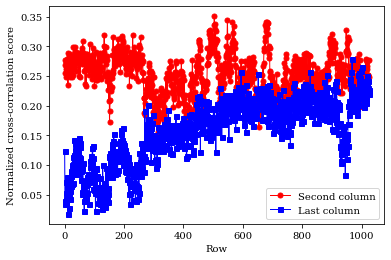

In [12]:
fig, ax = plt.subplots()
ax.plot(ncc2_01, "r-o", label="Second column")
ax.plot(ncc2_0last, "b-s", label="Last column")
ax.set_xlabel("Row")
ax.set_ylabel("Normalized cross-correlation score")
ax.legend();

Do we have to de-wrap a second time?

In [13]:
if ncc2_0last.mean() > ncc_01.mean():
    print("De-wrap!")
else:
    print("Don't de-wrap")

Don't de-wrap


The new first column (previously second column) is now more similar to the new second column
(previously third column) than the new last column (previously first column), which is what
we expect.

Finally, save the de-wrapped signal to file.

In [14]:
s2.save(os.path.join(dir_kp, "patterns_dewrap.h5"))